In [50]:
from scipy.interpolate import (
    LinearNDInterpolator,
    NearestNDInterpolator,
    CloughTocher2DInterpolator,
    Rbf,
)

import matplotlib.pyplot as plt
import firedrake
import firedrake_adjoint

from firedrake import Constant, cos, sin

import numpy as np
from numpy import pi as π
from numpy import random

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os, sys

currentdir = os.path.dirname(os.path.realpath('__file__'))

import argparse

parser = argparse.ArgumentParser(description='Estimate q using pyadjoint with a given number of point samples of u_true and chosen method. Expects to find a Firedrake checkpoint file \'true-fields.h5\' in the import directory.')
parser.add_argument('num_points', type=int, help='The number of points to sample from u_true. Points and measurements be identified from \'observed-data.h5\' or created and saved to it.')
parser.add_argument('method', help="The method to use: one of point-cloud, nearest, linear, clough-tocher, or gaussian")
try:
    args = parser.parse_args()
    num_points = args.num_points
    method = args.method
except:
    import warnings
    warnings.warn(f'Failed to parse arguments. Defaulting to num_points = 4 and method = point-cloud')
    num_points = 100
    method = 'point-cloud'

methods = ['point-cloud', 'nearest', 'linear', 'clough-tocher', 'gaussian']

# If running as notebook use default of 4 points and method 'point-cloud'
if method not in methods:
    import warnings
    warnings.warn(f'Got unexpected method argument {method} defaulting to point-cloud')
    method = 'point-cloud'
    
print(f"Running with {num_points} points and method {method}")

seed = 1729

Running with 100 points and method point-cloud


usage: ipykernel_launcher.py [-h] num_points method
ipykernel_launcher.py: error: argument num_points: invalid int value: '/Users/andrew/Library/Jupyter/runtime/kernel-48aef89c-4fdf-4d62-bb2b-75497c51cd2a.json'
<ipython-input-50-86f412619182>:36: UserWarning: Failed to parse arguments. Defaulting to num_points = 4 and method = point-cloud
  warnings.warn(f'Failed to parse arguments. Defaulting to num_points = 4 and method = point-cloud')


In [51]:
mesh = firedrake.UnitSquareMesh(32, 32)

# Solution Space
V = firedrake.FunctionSpace(mesh, family='CG', degree=2)

# q (Control) Space
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)

In [52]:

import h5py

filename = os.path.join(currentdir, 'observed-data.h5')

with h5py.File(filename, 'r') as file:
    xs = file[f"xs_{num_points}"][:]
    u_obs_vals = file[f"u_obs_vals_{num_points}"][:]
    σ = firedrake.Constant(file[f"sigma_{num_points}"])
    print(f"Loaded xs, u_obs_vals and sigma for {num_points} points.")

Loaded xs, u_obs_vals and sigma for 100 points.


In [53]:
f = Constant(1.0)
k0 = Constant(0.5)
α = firedrake.Constant(0.5)

In [54]:
from firedrake import exp, inner, grad, dx

print('Running forward model')
u = firedrake.Function(V)
v = firedrake.TestFunction(V)
q = firedrake.Function(Q)
bc = firedrake.DirichletBC(V, 0, 'on_boundary')
F = (k0 * exp(q) * inner(grad(u), grad(v)) - f * v) * dx
firedrake.solve(F == 0, u, bc)

Running forward model


In [55]:
if method == 'point-cloud':

    # Store data on the point_cloud using a vertex only mesh
    print('Creating VertexOnlyMesh')
    point_cloud = firedrake.VertexOnlyMesh(mesh, xs)
    print('Creating P0DG(VertexOnlyMesh) space')
    P0DG = firedrake.FunctionSpace(point_cloud, 'DG', 0)
    print('Creating u_obs')
    u_obs = firedrake.Function(P0DG, name=f'u_obs_{method}_{num_points}')
    u_obs.dat.data[:] = u_obs_vals
    
    print('Assembling J')
    misfit_expr = 0.5 * ((u_obs - firedrake.interpolate(u, P0DG)) / σ)**2

else:

    # Interpolating the mesh coordinates field (which is a vector function space)
    # into the vector function space equivalent of our solution space gets us
    # global DOF values (stored in the dat) which are the coordinates of the global
    # DOFs of our solution space. This is the necessary coordinates field X.
    print('Getting coordinates field X')
    Vc = firedrake.VectorFunctionSpace(mesh, V.ufl_element())
    X = firedrake.interpolate(mesh.coordinates, Vc).dat.data_ro[:]

    # Pick the appropriate "interpolate" method needed to create
    # u_interpolated given the chosen method
    print(f'Creating {method} interpolator')
    if method == 'nearest':
        interpolator = NearestNDInterpolator(xs, u_obs_vals)
    elif method == 'linear':
        interpolator = LinearNDInterpolator(xs, u_obs_vals, fill_value=0.0)
    elif method == 'clough-tocher':
        interpolator = CloughTocher2DInterpolator(xs, u_obs_vals, fill_value=0.0)
    elif method == 'gaussian':
        interpolator = Rbf(xs[:, 0], xs[:, 1], u_obs_vals, function='gaussian')
    print('Interpolating to create u_interpolated')
    u_interpolated = firedrake.Function(V, name=f'u_interpolated_{method}_{num_points}')
    u_interpolated.dat.data[:] = interpolator(X[:, 0], X[:, 1])
    
    print('Assembling J\'\'\'')
    misfit_expr = num_points * 0.5 * ((u_interpolated - u) / σ)**2    
    
regularisation_expr = 0.5 * α**2 * inner(grad(q), grad(q))
# Assembled J is here either J or J_prime_prime depending on the misfit expression
J = firedrake.assemble(misfit_expr * dx) + firedrake.assemble(regularisation_expr * dx)

Creating VertexOnlyMesh
Creating P0DG(VertexOnlyMesh) space
Creating u_obs
Assembling J


In [56]:
print('Getting q̂ (control varaible) and Ĵ (reduced functional)')
q̂ = firedrake_adjoint.Control(q)
Ĵ = firedrake_adjoint.ReducedFunctional(J, q̂)

print('Minimising Ĵ to get q_min')
q_min = firedrake_adjoint.minimize(
    Ĵ, method='Newton-CG', options={'disp': True}
)
# Rename for saving
q_min.rename(name=f'q_min_{method}_{num_points}')

Getting q̂ (control varaible) and Ĵ (reduced functional)
Minimising Ĵ to get q_min
Optimization terminated successfully.
         Current function value: 35.604543
         Iterations: 28
         Function evaluations: 33
         Gradient evaluations: 33
         Hessian evaluations: 1165


In [57]:
u_true = firedrake.Function(V)
q_true = firedrake.Function(Q)

filename = os.path.join(currentdir, 'true-fields')
with firedrake.DumbCheckpoint(filename, mode=firedrake.FILE_READ) as chk:
    chk.load(q_true, name='q_true')
    chk.load(u_true, name='u_true')

print('Calculating q error field')
q_err = firedrake.Function(Q, name=f'q_err_{method}_{num_points}').assign(q_min-q_true)
print('Calculating L2 error norm')
l2norm = firedrake.norm(q_err, "L2")

Calculating q error field
Calculating L2 error norm


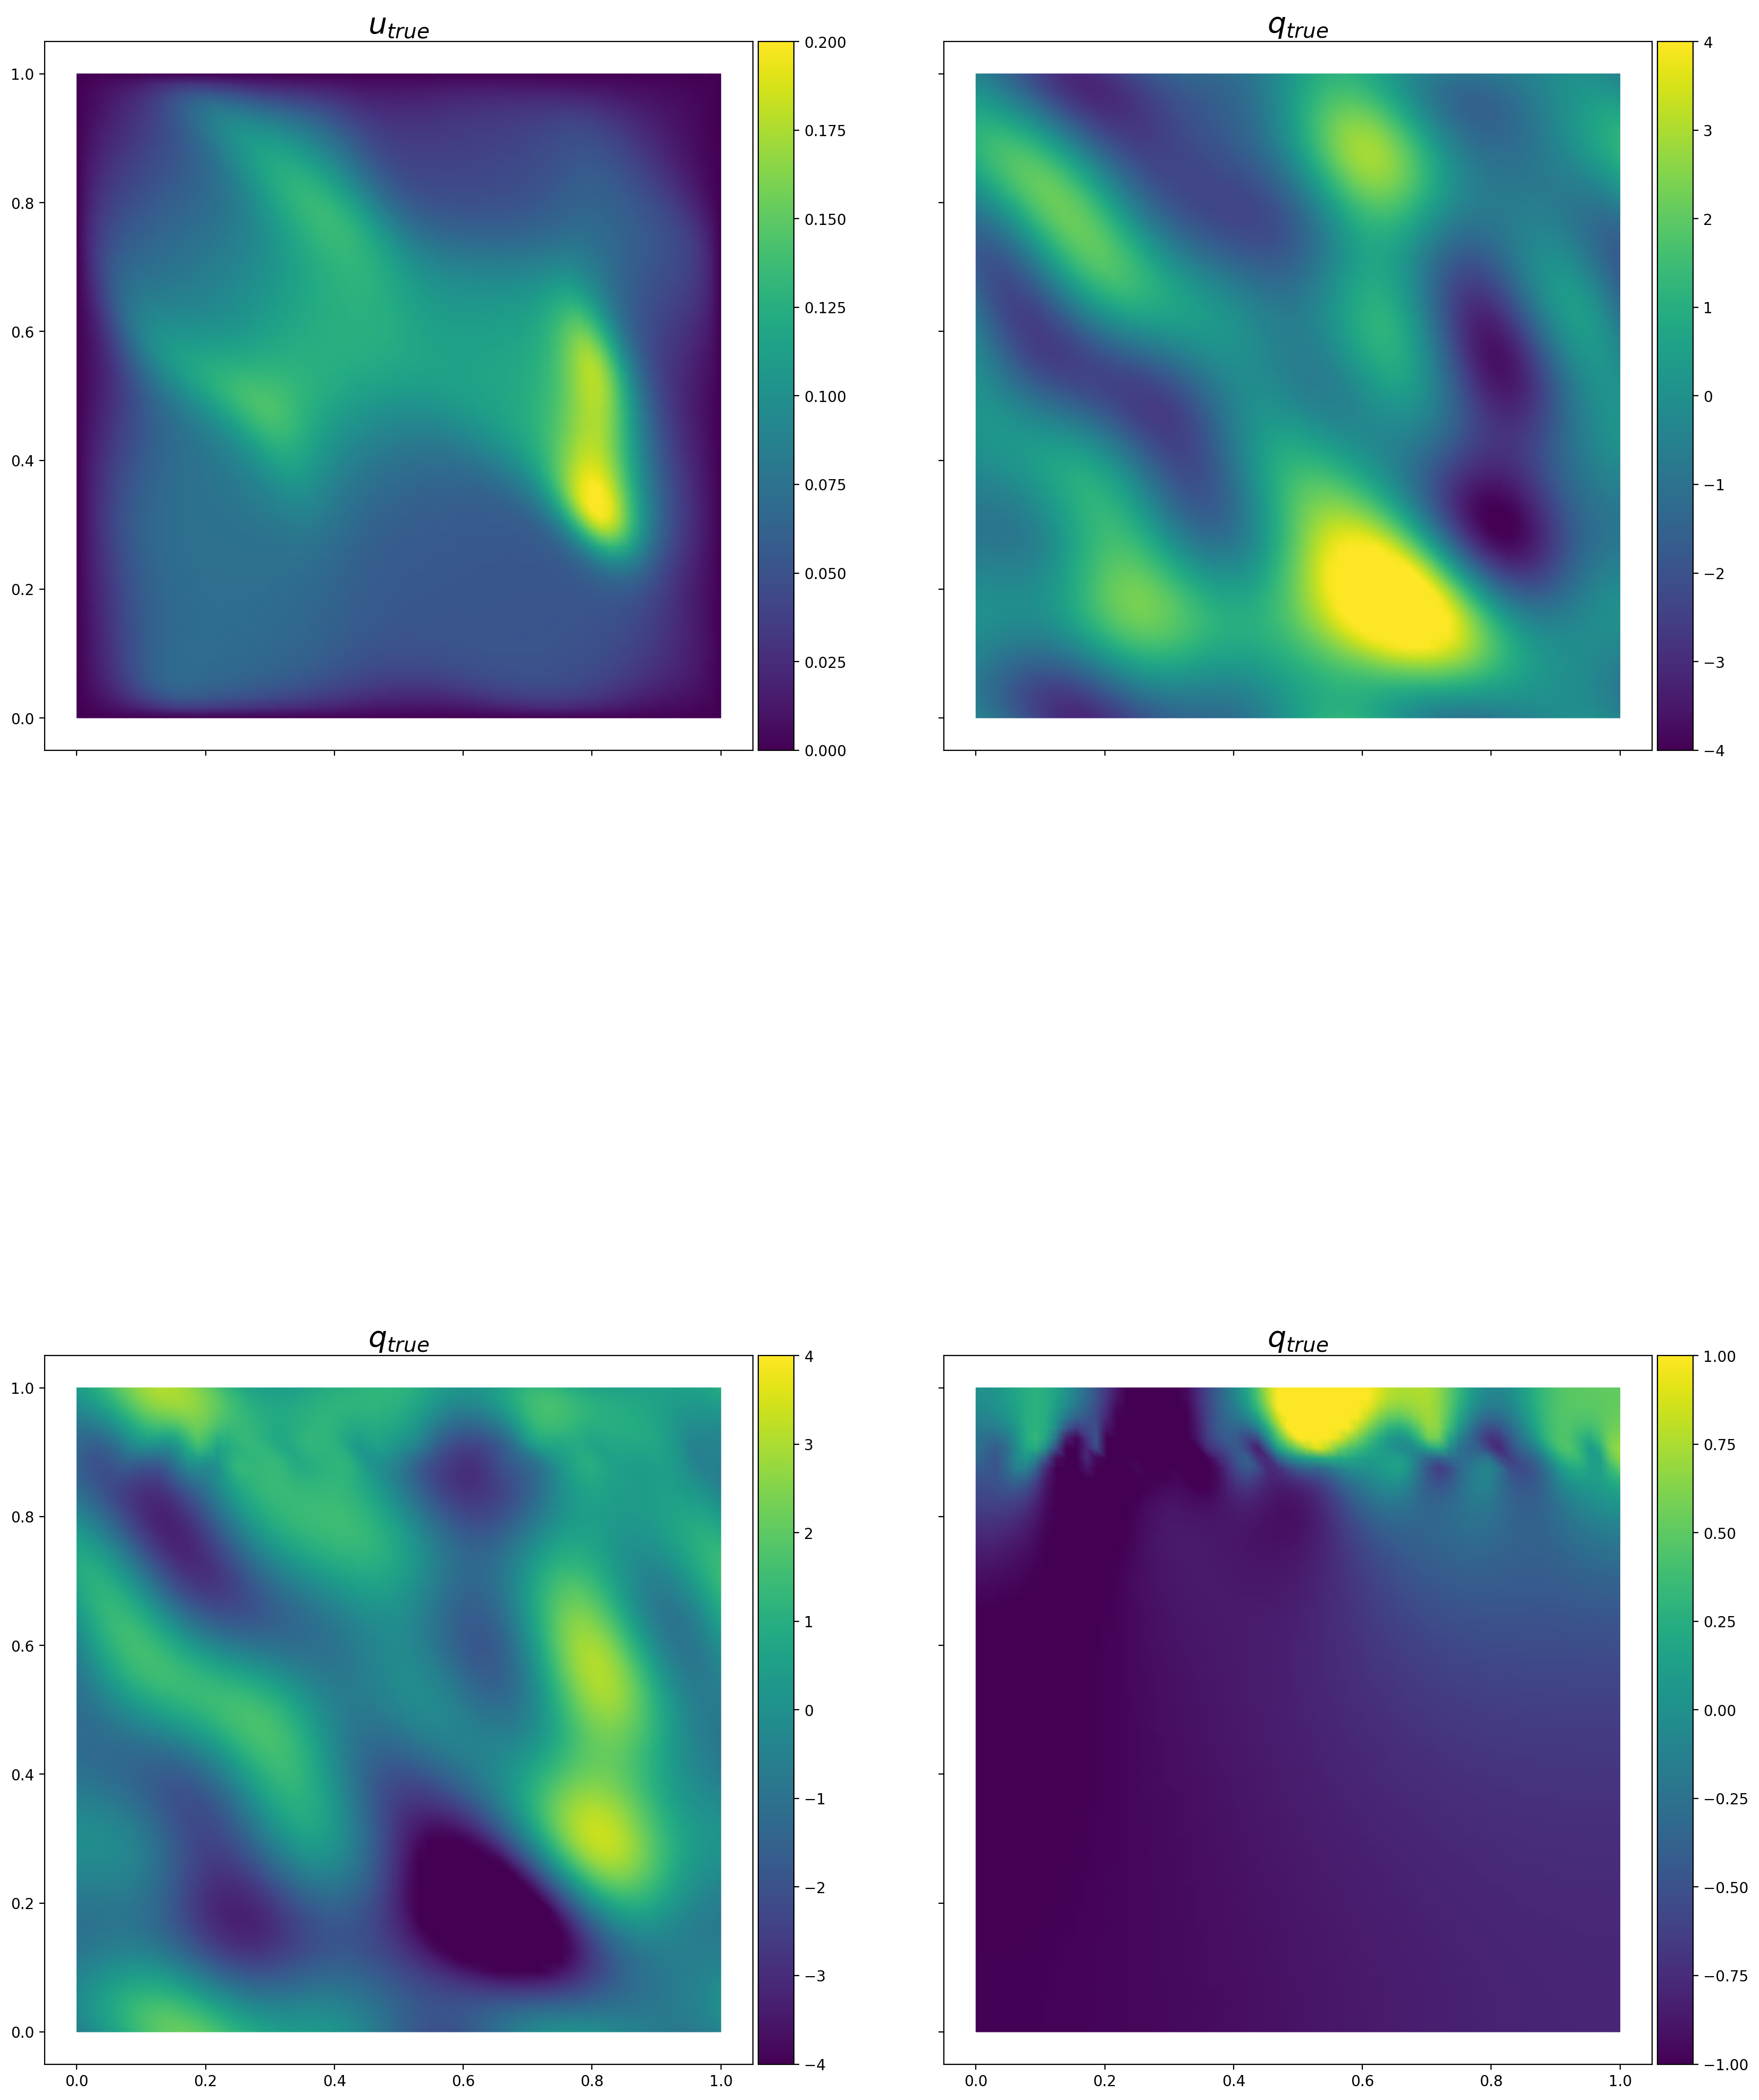

In [62]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex=True, sharey=True, figsize=(20,30), dpi=200)
for ax in axes.ravel():
    ax.set_aspect('equal')
ukw = {'vmin': 0.0, 'vmax': +0.2}
kw = {'vmin': -4, 'vmax': +4, 'shading': 'gouraud'}
kw1 = {'vmin': -1, 'vmax': +1, 'shading': 'gouraud'}
title_fontsize = 20
text_fontsize = 20
axes[0,0].set_title('$u_{true}$', fontsize=title_fontsize)
colors = firedrake.tripcolor(u_true, axes=axes[0,0], shading='gouraud', **ukw)
cax = make_axes_locatable(axes[0,0]).append_axes("right", size="5%", pad=0.05)
fig.colorbar(colors, cax=cax)

axes[0, 1].set_title('$q_{true}$', fontsize=title_fontsize)
colors = firedrake.tripcolor(q_true, axes=axes[0, 1], **kw)
cax = make_axes_locatable(axes[0, 1]).append_axes("right", size="5%", pad=0.05)
fig.colorbar(colors, cax=cax)

axes[1, 0].set_title('$q_{true}$', fontsize=title_fontsize)
colors = firedrake.tripcolor(q_err, axes=axes[1, 0], **kw)
cax = make_axes_locatable(axes[1, 0]).append_axes("right", size="5%", pad=0.05)
fig.colorbar(colors, cax=cax)

axes[1, 1].set_title('$q_{true}$', fontsize=title_fontsize)
colors = firedrake.tripcolor(q_min, axes=axes[1, 1], **kw1)
cax = make_axes_locatable(axes[1, 1]).append_axes("right", size="5%", pad=0.05)
fig.colorbar(colors, cax=cax)

In [59]:

num_points_set = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144]
methods = ['point-cloud', 'nearest', 'linear', 'clough-tocher', 'gaussian']
l2_q_norms = {method: [] for method in methods}
l2_u_norms = {method: [] for method in methods}

<ipython-input-60-02d21ac70c53>:3: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

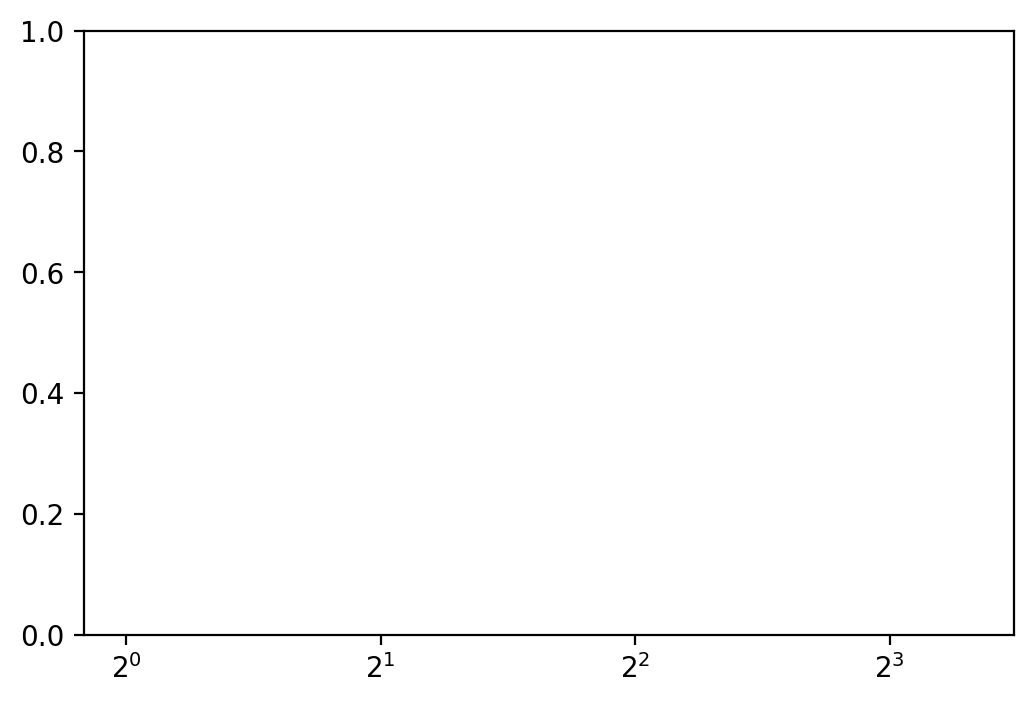

In [60]:
cmap = plt.get_cmap("tab10")
fig, ax = plt.subplots(dpi=200)
ax.set_xscale('log', basex=2)
for i, method in enumerate(methods):
    arr = np.asarray(l2_q_norms[method])
    method_num_points = arr[:,0]
    method_l2_q_norms = arr[:,1]
    ax.plot(method_num_points, method_l2_q_norms, marker='o', color=cmap(i))
ax.legend(methods, title='Method')
ax.set_xlabel('Number of Points N')
ax.set_ylabel('$||q_{est}-q_{true}||_{L^2}$')
ax.set_title('Estimating Log-Conductivity $q$ \n    where $k = k_0e^q$ and $-\\nabla \\cdot k \\nabla u = f$ for known $f$')
plt.savefig(f'l2_q_norms.png')